<a href="https://colab.research.google.com/github/sooonsyk/ESAA-22-2/blob/main/W15_HW_mon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#합성공 신경망
##01. 합성곱 신경망 Convolutional Neural Network
: 데이터가 가진 특징들의 패턴 학습 알고리즘
  - 객체 탐지 :  이미지에서 특정한 객채를 인식하고 이미지의 어디에 있는지 위치까지 파악하는 기술
  - 스타일 전이 : 콘텐츠 이미지와 스타일 참조 이미지를 이용해 콘텐츠의 기본 형태를 유지하고 스타일을 입혀서 새로운 이미지를 생성하는 기술
  

###1-1 이미지 표현
- 이미지 또는 영상을 컴퓨터가 이해할 수 있게 하려면 숫자로 표현해야 함
  - 화소를 나타내는 숫자는 이미지의 강도를 나타내고 숫자가 클수록 더 강한 특성을 나타냄
  - 컬러이미지는 RGB 채널로 구성된 3장의 이미지 겹쳐서 표현 

###1-2 합성곱 convolution
- 입력 이미지에 대하여 일반적으로 정방형 크기를 가지는 커널을 사용하여 입력 이미지에 대한 특성을 추출하는 방법
  - 입력 이미지의 좌측 상단부터 커널과 같은 크기를 갖도록 입력이미지의 일부분에 커널이 겹치게 투영, 겹치는 부분에 대하여 합성곱 연산 수행
  - 연산 값들이 모여 특성맵 구성
- 특성맵 feature map : 합성곱 연산을 통해서 추출된 이미지
- 커널 사이즈가 3x3인 경우 9개의 가중치를 가지며 오차 역전파시 커널의 가중치 업데이트
- 커널의 공유 가중치 때문에 합성곱 신경망이 이미지 특성 추출에 효율적, 오차 역전파시 완전 연결층 사용할 때보다 연산량 훨씬 적음

###1-3 채널 Channel
- 입력 이미지를 구성하는 2차원 배열의 개수
- 입력이미지가 여러 개의 채널을 갖는 경우 그 개수만큼 커널이 생성되고 각 채널마다 하나씩 커널을 적용하여 합성곱 연산 수행, 개수만큼 생성된 특성맵을 element wise 덧셈으로 더해주면 최종 특성맵 생성

###1-4 스트라이드 stride
- 커널이 좌측 상단으로부터 입력 이미지를 기준으로 우측으로 이동하면서 합성곱 연산을 계속 수행하며 특성맵을 채워나갈 때 이동하는 간격, 주로 1 혹은 2로 설정
  - 2로 설정하면 특성맵의 크기가 반으로 줄어듦

###1-5 패딩 padding
- 추출된 특성맵의 크기가 입력 이미지 대비 줄어들지 않도록 설정
- zero padding : 입력 이미지의 가장 자리에 0으로 채워진 패딩 값으로 채운 후 추출

###1-6 특성맵 사이즈
$(Output Height, Output Width) = ( \frac{Image Height + 2P - Kernel Height}{S}+1, \frac{Image Width + 2P - Kernel Width}{S}+1)$

###1-7 풀링 pooling
- 풀링 레이어 : 추출된 특성맵에 대해 다운 샘플링하여 이미지의 크기를 축소하는 레이어
- 이미지 축소를 통해 연산량을 감소하고 과대적합을 방지
- max pooling : 특징의 값이 큰 값이 다른 특징들을 대표, 최댓값 사용
  - 스트라이드 설정 가능, 2로 설정시 입력 이미지 대시 1/4로 크기 줆
- average pooling : 평균값 사용

##02 간단한 모델 생성

###2-1 데이터 로드 및 전처리

In [32]:
import tensorflow as tf
import numpy as np

mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_valid, y_valid) = mnist.load_data()

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


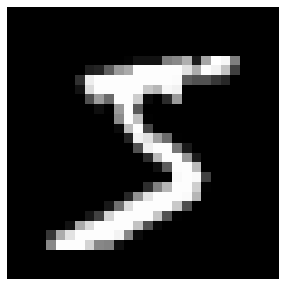

In [ ]:
import matplotlib.pyplot as plt

def plot_image(data,idx):
  plt.figure(figsize=(5,5))
  plt.imshow(data[idx], cmap='gray')
  plt.axis('off')
  plt.show()

#첫번째 이미지
plot_image(x_train,0)

In [ ]:
#이미지 픽셀값 최대 최소
print(x_train.min(), x_train.max())
print(x_valid.min(), x_valid.max())

0 255
0 255


In [ ]:
#정규화 - 안정적인 학습
x_train = x_train/255.0
x_valid = x_valid/255.0

print(x_train.min(), x_train.max())
print(x_valid.min(), x_valid.max())

0.0 1.0
0.0 1.0


In [ ]:
#모노 컬러 이미지 채널 추가
print(x_train.shape, x_valid.shape)

x_train_in = x_train[..., tf.newaxis] #마지막 축에 채널 추가
x_valid_in = x_valid[..., tf.newaxis]

print(x_train_in.shape, x_valid_in.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 28, 28, 1) (10000, 28, 28, 1)


###2-2 Sequential API로 모델 생성 및 학습


In [ ]:
model = tf.keras.Sequential([
    #Convolution 적용(32 filters)
    tf.keras.layers.Conv2D(32,(3,3),              #(3,3)크기의 서로 다른 32가지 종류의 커널
                           activation='relu', 
                           input_shape=(28,28,1),
                           name = 'conv'),
    
    #Max pooling 적용
    tf.keras.layers.MaxPooling2D((2,2), name='pool'),
    #Classifier 출력층
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
    
    ])

In [ ]:
#모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics = ['accuracy'])

#모델 훈련
history = model.fit(x_train_in, y_train,
                    validation_data = (x_valid_in, y_valid),
                    epochs=10)

Epoch 1/10
1875/1875 [==============================] - 49s 25ms/step - loss: 0.2421 - accuracy: 0.9306 - val_loss: 0.1058 - val_accuracy: 0.9686
Epoch 2/10
1875/1875 [==============================] - 42s 22ms/step - loss: 0.0894 - accuracy: 0.9744 - val_loss: 0.0795 - val_accuracy: 0.9751
Epoch 3/10
1875/1875 [==============================] - 35s 18ms/step - loss: 0.0646 - accuracy: 0.9810 - val_loss: 0.0590 - val_accuracy: 0.9817
Epoch 4/10
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0530 - accuracy: 0.9844 - val_loss: 0.0609 - val_accuracy: 0.9812
Epoch 5/10
1875/1875 [==============================] - 42s 23ms/step - loss: 0.0438 - accuracy: 0.9872 - val_loss: 0.0518 - val_accuracy: 0.9843
Epoch 6/10
1875/1875 [==============================] - 42s 22ms/step - loss: 0.0382 - accuracy: 0.9880 - val_loss: 0.0490 - val_accuracy: 0.9847
Epoch 7/10
1875/1875 [==============================] - 42s 23ms/step - loss: 0.0320 - accuracy: 0.9901 - val_loss: 0.0502 -

In [ ]:
#모델의 학습된 가중치를 사용하여 손실과 평가지표 계산
model.evaluate(x_valid_in, y_valid)

313/313 [==============================] - 3s 8ms/step - loss: 0.0562 - accuracy: 0.9828


[0.056242436170578, 0.9828000068664551]

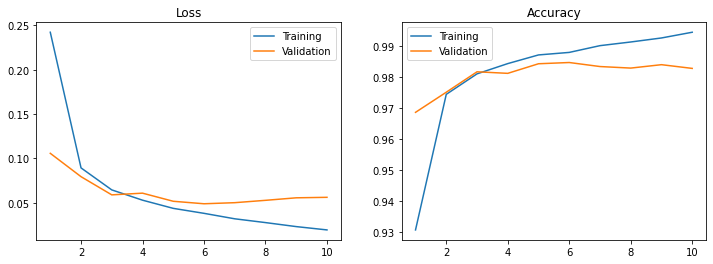

In [ ]:
#예측 오차와 정확도 그래프로
def plot_loss_acc(history, epoch):
    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
    
    fig, axes = plt.subplots(1,2,figsize=(12,4))
    
    axes[0].plot(range(1, epoch+1), loss, label = 'Training')
    axes[0].plot(range(1, epoch+1), val_loss, label = "Validation")
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch+1), acc, label = 'Training')
    axes[1].plot(range(1, epoch+1), val_acc, label = "Validation")
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')
    
    plt.show()
    
plot_loss_acc(history, 10) # 4이후부터 과대적합

###2-3 모델 구조 파악


In [ ]:
#모델 구조
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv (Conv2D)               (None, 26, 26, 32)        320       
                                                                 
 pool (MaxPooling2D)         (None, 13, 13, 32)        0         
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 10)                54090     
                                                                 
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#입력 텐서 형태
model.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv_input')>

In [ ]:
#출력 텐서 형태
model.output

<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense')>

In [ ]:
#레이어
model.layers

In [ ]:
#첫번째 레이어
model.layers[0]

In [ ]:
#첫번째 레이어 입력
model.layers[0].input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv_input')>

In [ ]:
#첫번째 레이어 출력
model.layers[0].output

<KerasTensor: shape=(None, 26, 26, 32) dtype=float32 (created by layer 'conv')>

In [ ]:
#첫번째 레이어 가중치 - 합성곱 필터 커널 행렬의 가중치, 각 커널의 상수항
model.layers[0].weights

[<tf.Variable 'conv/kernel:0' shape=(3, 3, 1, 32) dtype=float32, numpy=
 array([[[[-1.5150702 , -0.1524036 ,  0.18185388,  0.17843886,
            0.33390832,  0.40636015,  0.35388693, -0.11600509,
           -0.77325433,  0.38113886, -0.60977924,  0.35724467,
           -1.0385202 ,  0.2139338 , -0.41969708, -0.3455717 ,
           -0.9151152 , -0.07297441,  0.3651903 ,  0.36433753,
           -0.54644126,  0.27873886, -0.11817159, -0.45720094,
           -0.93724185,  0.19169156, -0.08779652,  0.09808005,
            0.16177331, -0.4852427 ,  0.12239453, -0.7664227 ]],
 
         [[-0.9496863 ,  0.21489865,  0.7375497 , -0.180851  ,
            0.21022147,  0.24007231,  0.4791919 ,  0.0752819 ,
            0.0386845 , -0.06943044,  0.2365819 ,  0.09941396,
           -1.0800991 , -0.27037144, -0.74464655,  0.11975917,
           -0.41742527, -0.29938677,  0.53015506,  0.10031971,
           -0.06848641,  0.24106798,  0.21597457, -0.74518836,
           -0.59974164,  0.23678075,  0.56

In [ ]:
#첫번째 레이어 커널 가중치
model.layers[0].kernel

<tf.Variable 'conv/kernel:0' shape=(3, 3, 1, 32) dtype=float32, numpy=
array([[[[-1.5150702 , -0.1524036 ,  0.18185388,  0.17843886,
           0.33390832,  0.40636015,  0.35388693, -0.11600509,
          -0.77325433,  0.38113886, -0.60977924,  0.35724467,
          -1.0385202 ,  0.2139338 , -0.41969708, -0.3455717 ,
          -0.9151152 , -0.07297441,  0.3651903 ,  0.36433753,
          -0.54644126,  0.27873886, -0.11817159, -0.45720094,
          -0.93724185,  0.19169156, -0.08779652,  0.09808005,
           0.16177331, -0.4852427 ,  0.12239453, -0.7664227 ]],

        [[-0.9496863 ,  0.21489865,  0.7375497 , -0.180851  ,
           0.21022147,  0.24007231,  0.4791919 ,  0.0752819 ,
           0.0386845 , -0.06943044,  0.2365819 ,  0.09941396,
          -1.0800991 , -0.27037144, -0.74464655,  0.11975917,
          -0.41742527, -0.29938677,  0.53015506,  0.10031971,
          -0.06848641,  0.24106798,  0.21597457, -0.74518836,
          -0.59974164,  0.23678075,  0.56247663,  0.348920

In [ ]:
#첫번째 레이어 bias 가중치
model.layers[0].bias

<tf.Variable 'conv/bias:0' shape=(32,) dtype=float32, numpy=
array([-0.00116405, -0.08338337, -0.08207726, -0.29596248, -0.37447128,
       -0.27118793, -0.18148187, -0.01801361, -0.0060199 , -0.26395044,
       -0.1783026 , -0.47870603,  0.21455929, -0.15442696, -0.05326355,
       -0.04620951, -0.11630322, -0.15925744, -0.0222556 , -0.4125985 ,
       -0.25446546, -0.46526122, -0.34362018, -0.1225557 , -0.01071518,
       -0.31819218, -0.40614456, -0.01224889, -0.24659656, -0.24717364,
       -0.18997253, -0.00476687], dtype=float32)>

In [ ]:
#레이어 이름으로 레이어 선택
model.get_layer('conv')

In [ ]:
#샘플 이미지에 레이어별 출력을 리스트에 추가
activator = tf.keras.Model(inputs=model.input, #입력 데이터
                           outputs=[layer.output for layer in model.layers[:2]]) #첫번째, 두번째 레이어의 출력을 최종 출력으로 갖는 activator 모델
activations = activator.predict(x_train_in[0][tf.newaxis,...]) #첫번째 샘플에 대하여 각 레이어의 출력 예측

len(activations)

1/1 [==============================] - 0s 77ms/step


2

In [ ]:
#첫번째 레이어 conv 출력층
conv_activation = activations[0]
conv_activation.shape

(1, 26, 26, 32)

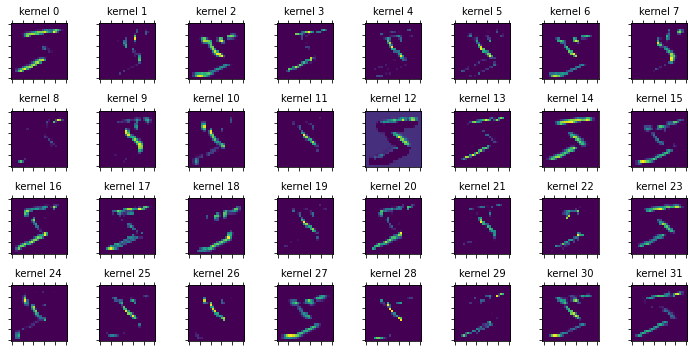

In [28]:
#특성맵 이미지 커널별로 구분하여 시각화
fig, axes = plt.subplots(4,8)
fig.set_size_inches(10,5)

for i in range(32):
    axes[i//8, i%8].matshow(conv_activation[0,:,:,i], cmap='viridis')
    axes[i//8, i%8].set_title('kernel %s'%str(i), fontsize=10)
    plt.setp(axes[i//8, i%8].get_xticklabels(), visible = False)
    plt.setp(axes[i//8, i%8].get_yticklabels(), visible = False)
    
plt.tight_layout()
plt.show()
#출ㄹ력 이미지의 특징 조금씩 차이남 - 각 커널은 입력 이미지로부터 서로 다른 피처를 추출하는 역할함

In [29]:
#두번째 레이어 출력층 - 최대 풀링 레이어
pooling_activation = activations[1]
print(pooling_activation.shape)

(1, 13, 13, 32)


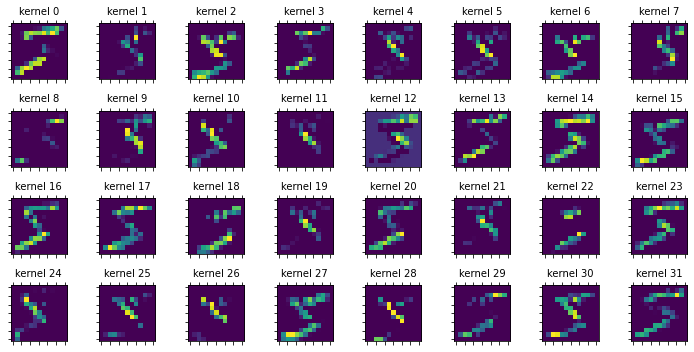

In [30]:
fig, axes = plt.subplots(4,8)
fig.set_size_inches(10,5)

for i in range(32):
    axes[i//8, i%8].matshow(pooling_activation[0,:,:,i], cmap='viridis')
    axes[i//8, i%8].set_title('kernel %s'%str(i), fontsize=10)
    plt.setp(axes[i//8, i%8].get_xticklabels(), visible = False)
    plt.setp(axes[i//8, i%8].get_yticklabels(), visible = False)
    
plt.tight_layout()
plt.show()
#화소 크기 보다 굵어짐 - 최댓값으로 고정하기 때문에 픽셀 수를 줄이면서 특징 더욱 강하게 드러냄

##03 복잡한 모델 생성

###3-1 데이터셋 준비

In [33]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_valid, y_valid) = mnist.load_data()

print(x_train.shape, y_train.shape) 
print(x_valid.shape, y_valid.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [34]:
#숫자 맞추는 정답 외에 홀수 짝수 판단하는 y_odds 추가

y_train_odd=[]
for y in y_train:
  if y%2==0:
    y_train_odd.append(0)
  else:
    y_train_odd.append(1)

y_train_odd = np.array(y_train_odd)
y_train_odd.shape

(60000,)

In [35]:
print(y_train[:10])
print(y_train_odd[:10])

[5 0 4 1 9 2 1 3 1 4]
[1 0 0 1 1 0 1 1 1 0]


In [36]:
#검증 데이터셋에도
y_valid_odd=[]
for y in y_valid:
  if y%2==0:
    y_valid_odd.append(0)
  else:
    y_valid_odd.append(1)

y_valid_odd = np.array(y_valid_odd)
y_valid_odd.shape

(10000,)

In [37]:
# 정규화
x_train = x_train/255.0
x_valid = x_valid/255.0

# 채널 추가
x_train_in = tf.expand_dims(x_train, -1)  #원본 배열 입력하고 새롭게 추가하려는 축의 인덱스 지정하면 해당 인덱스에 새로운 축 추가 - 마지막에 모노 컬러 이미지이므로 채널 1개
x_valid_in = tf.expand_dims(x_valid, -1)

print(x_train_in.shape, x_valid_in.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


### 3-3 Fuctional API 다중 입력, 다중 출력 레이어 생성

In [38]:
# Functional API를 이용하여 모델 생성
inputs = tf.keras.layers.Input(shape=(28,28,1))  #conv와 flat_inputs 레이어의 입력으로 사용 - 2개의 출력 가짐 - 각각 다른 레이어의 입력으로 사용된

conv = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inputs)
pool = tf.keras.layers.MaxPooling2D((2,2))(conv)
flat = tf.keras.layers.Flatten()(pool)

flat_inputs = tf.keras.layers.Flatten()(inputs)
concat = tf.keras.layers.Concatenate()([flat, flat_inputs])          #서로 다른 레이어들의 출력이 합쳐짐
outputs = tf.keras.layers.Dense(10, activation='softmax')(concat)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 26, 26, 32)   320         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 13, 13, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 flatten_1 (Flatten)            (None, 5408)         0           ['max_pooling2d[0][0]']          
                                                                                            

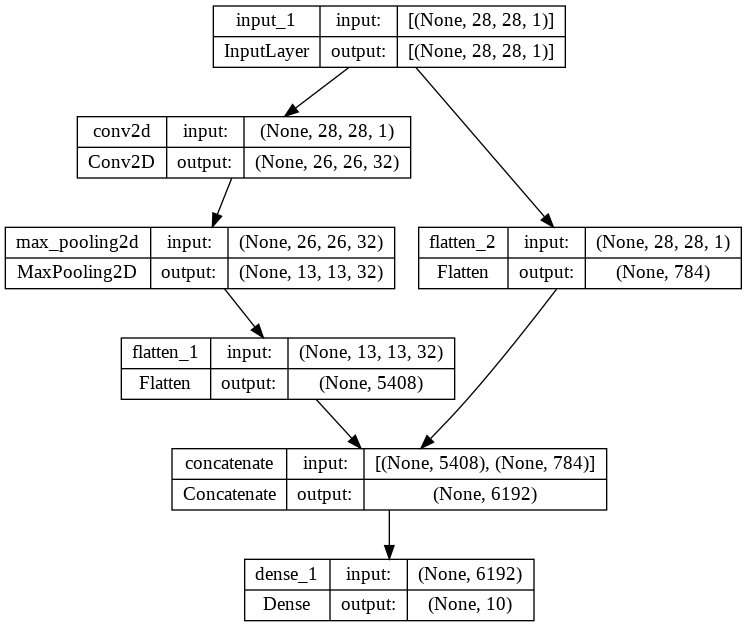

In [39]:
# 모델 구조 출력 및 이미지 파일로 저장
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='functional_cnn.png')

In [40]:
#모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#모델 훈련
history = model.fit(x_train_in, y_train, validation_data = (x_valid_in, y_valid),epochs=10)

#모델 성능
val_loss, val_acc = model.evaluate(x_valid_in, y_valid)
print(val_loss, val_acc)

Epoch 1/10
1875/1875 [==============================] - 42s 22ms/step - loss: 0.2127 - accuracy: 0.9394 - val_loss: 0.0890 - val_accuracy: 0.9738
Epoch 2/10
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0791 - accuracy: 0.9771 - val_loss: 0.0701 - val_accuracy: 0.9776
Epoch 3/10
1875/1875 [==============================] - 40s 21ms/step - loss: 0.0608 - accuracy: 0.9819 - val_loss: 0.0716 - val_accuracy: 0.9774
Epoch 4/10
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0493 - accuracy: 0.9850 - val_loss: 0.0537 - val_accuracy: 0.9821
Epoch 5/10
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0409 - accuracy: 0.9873 - val_loss: 0.0557 - val_accuracy: 0.9819
Epoch 6/10
1875/1875 [==============================] - 42s 22ms/step - loss: 0.0343 - accuracy: 0.9894 - val_loss: 0.0649 - val_accuracy: 0.9799
Epoch 7/10
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0283 - accuracy: 0.9915 - val_loss: 0.0544 -

### 3-3 다중 출력 분류 모델

In [41]:
inputs = tf.keras.layers.Input(shape=(28,28,1), name='inputs')

conv = tf.keras.layers.Conv2D(32, (3,3), activation='relu', name='conv2d_layer')(inputs)
pool = tf.keras.layers.MaxPooling2D((2,2), name='maxpool_layer')(conv)
flat = tf.keras.layers.Flatten(name='flaten_layer')(pool)

flat_inputs = tf.keras.layers.Flatten()(inputs)
concat = tf.keras.layers.Concatenate()([flat, flat_inputs])
digit_outputs = tf.keras.layers.Dense(10, activation='softmax', name='digit_dense')(concat) #어떤 숫자인지 분류
odd_outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='odd_dense')(flat_inputs) #홀짝 분류

model = tf.keras.models.Model(inputs=inputs, outputs=[digit_outputs, odd_outputs])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_layer (Conv2D)          (None, 26, 26, 32)   320         ['inputs[0][0]']                 
                                                                                                  
 maxpool_layer (MaxPooling2D)   (None, 13, 13, 32)   0           ['conv2d_layer[0][0]']           
                                                                                                  
 flaten_layer (Flatten)         (None, 5408)         0           ['maxpool_layer[0][0]']          
                                                                                            

In [42]:
#입력, 출력
print(model.input)
print(model.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='inputs'), name='inputs', description="created by layer 'inputs'")
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'digit_dense')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'odd_dense')>]


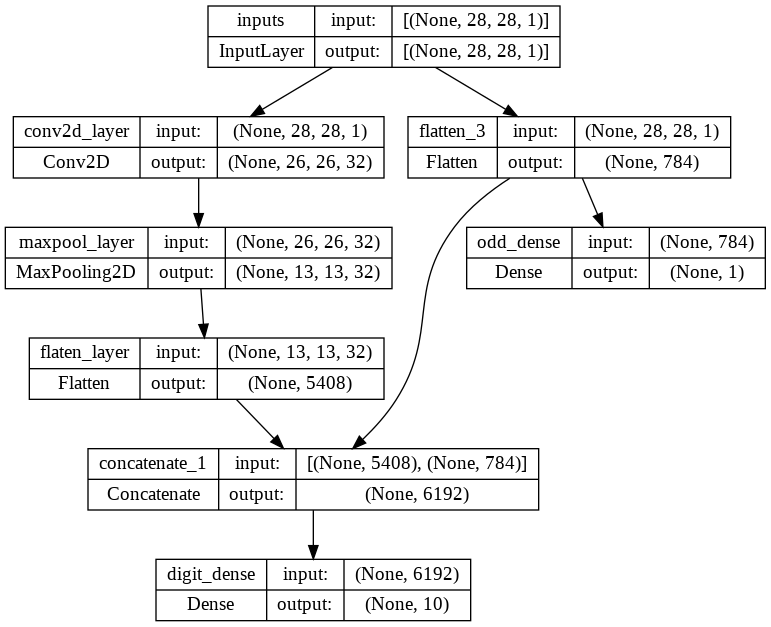

In [43]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='multi_output_cnn.png')

In [44]:
#각 레이어를 key 값으로 해당 레이어레 적용할 옵션들 딕셔너리 형태로 지정
#모델 컴파일
model.compile(optimizer='adam', loss={'digit_dense':'sparse_categorical_crossentropy',
                                      'odd_dense':'binary_crossentropy'},
              loss_weights={'digit_dense':1, 'odd_dense':0.5},
              # loss = 1.0*sparse_categorical_crossentropy + 0.5*binary_crossentropy
              metrics=['accuracy'])

#모델 훈련
history = model.fit({'inputs':x_train_in},{'digit_dense':y_train, 'odd_dense':y_train_odd},
                    validation_data = ({'inputs':x_valid_in}, {'digit_dense':y_valid,'odd_dense':y_valid_odd}),
                    epochs=10)

Epoch 1/10
1875/1875 [==============================] - 39s 20ms/step - loss: 0.3679 - digit_dense_loss: 0.2065 - odd_dense_loss: 0.3227 - digit_dense_accuracy: 0.9401 - odd_dense_accuracy: 0.8659 - val_loss: 0.2264 - val_digit_dense_loss: 0.0893 - val_odd_dense_loss: 0.2743 - val_digit_dense_accuracy: 0.9732 - val_odd_dense_accuracy: 0.8906
Epoch 2/10
1875/1875 [==============================] - 43s 23ms/step - loss: 0.2172 - digit_dense_loss: 0.0812 - odd_dense_loss: 0.2721 - digit_dense_accuracy: 0.9759 - odd_dense_accuracy: 0.8912 - val_loss: 0.2021 - val_digit_dense_loss: 0.0704 - val_odd_dense_loss: 0.2634 - val_digit_dense_accuracy: 0.9778 - val_odd_dense_accuracy: 0.8978
Epoch 3/10
1875/1875 [==============================] - 47s 25ms/step - loss: 0.1928 - digit_dense_loss: 0.0613 - odd_dense_loss: 0.2630 - digit_dense_accuracy: 0.9817 - odd_dense_accuracy: 0.8959 - val_loss: 0.1934 - val_digit_dense_loss: 0.0631 - val_odd_dense_loss: 0.2605 - val_digit_dense_accuracy: 0.9796 -

In [45]:
#모델 성능
model.evaluate({'inputs':x_train_in},{'digit_dense':y_train, 'odd_dense':y_train_odd})

1875/1875 [==============================] - 20s 11ms/step - loss: 0.1378 - digit_dense_loss: 0.0117 - odd_dense_loss: 0.2521 - digit_dense_accuracy: 0.9968 - odd_dense_accuracy: 0.9025


[0.13777987658977509,
 0.01171291433274746,
 0.2521341145038605,
 0.9968166947364807,
 0.9024666547775269]

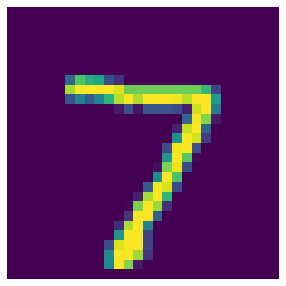

In [46]:
#샘플 이미지 출력
import matplotlib.pyplot as plt

def plot_image(data, idx):
  plt.figure(figsize=(5,5))
  plt.imshow(data[idx])
  plt.axis('off')
  plt.show()

plot_image(x_valid, 0)

In [47]:
#예측 확률
digit_preds, odd_preds = model.predict(x_valid_in)
print(digit_preds[0])
print(odd_preds[0])

313/313 [==============================] - 4s 11ms/step
[2.3242302e-12 2.7805117e-10 2.9934669e-10 1.2895933e-07 1.3299647e-11
 7.4020637e-14 4.9033569e-22 9.9999982e-01 1.8909119e-09 6.1689881e-10]
[0.99950093]


In [48]:
#예측 확률 정답 레이블로 변환
digit_labels = np.argmax(digit_preds, axis=-1)
digit_labels[0:10]

odd_labels = (odd_preds >0.5).astype(np.int).reshape(1, -1)[0]
odd_labels[0:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 6, 9])

###3-4 전이학습 Transfer Learning
- 기존에 학습된 모델을 활용해 새로운 모델 재구성

In [49]:
#앞의 모델에서 flatten_layer 출력을 추출
base_model_output = model.get_layer('flaten_layer').output # 오타

#앞의 출력을 출력으로 하는 모델 정의
base_model = tf.keras.models.Model(inputs=model.input, outputs=base_model_output, name='base')
base_model.summary()

Model: "base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flaten_layer (Flatten)      (None, 5408)              0         
                                                                 
Total params: 320
Trainable params: 320
Non-trainable params: 0
_________________________________________________________________


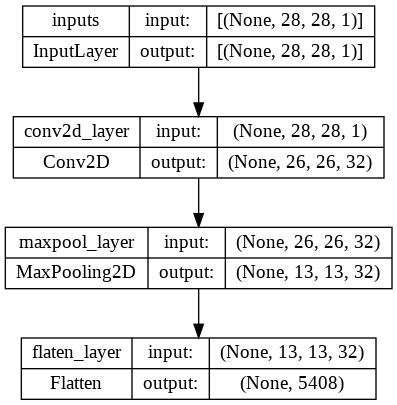

In [50]:
plot_model(base_model, show_shapes=True, show_layer_names=True, to_file='base_model.png')

In [51]:
digit_model = tf.keras.Sequential([
    base_model, 
    tf.keras.layers.Dense(10, activation='softmax'), # 최종 분류기 역할 Dense 레이어
])

digit_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base (Functional)           (None, 5408)              320       
                                                                 
 dense_2 (Dense)             (None, 10)                54090     
                                                                 
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________


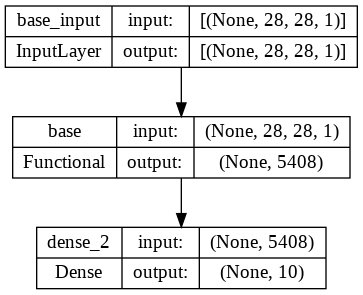

In [52]:
plot_model(digit_model, show_shapes=True, show_layer_names=True, to_file='digit_model.png')

In [53]:
digit_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

history = digit_model.fit(x_train_in, y_train, validation_data = (x_valid_in, y_valid),epochs=10)

Epoch 1/10
1875/1875 [==============================] - 40s 21ms/step - loss: 0.1294 - accuracy: 0.9647 - val_loss: 0.0729 - val_accuracy: 0.9761
Epoch 2/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0580 - accuracy: 0.9831 - val_loss: 0.0575 - val_accuracy: 0.9811
Epoch 3/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0440 - accuracy: 0.9866 - val_loss: 0.0514 - val_accuracy: 0.9849
Epoch 4/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0349 - accuracy: 0.9891 - val_loss: 0.0475 - val_accuracy: 0.9842
Epoch 5/10
1875/1875 [==============================] - 35s 19ms/step - loss: 0.0281 - accuracy: 0.9912 - val_loss: 0.0606 - val_accuracy: 0.9810
Epoch 6/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0234 - accuracy: 0.9931 - val_loss: 0.0512 - val_accuracy: 0.9826
Epoch 7/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0193 - accuracy: 0.9943 - val_loss: 0.0558 -

In [54]:
#베이스 모델의 가중치 고정(Freeze model)
base_model_frozen = tf.keras.models.Model(inputs=model.input, outputs=base_model_output, name='base_frozen')
base_model_frozen.trainable=False #모델의 파라미터 값이 고정되어 훈련의 통해 업데이트 되지 않음
base_model_frozen.summary() #훈련 가능한 파라미터 개수 0개임을 확인할 수 있음

Model: "base_frozen"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flaten_layer (Flatten)      (None, 5408)              0         
                                                                 
Total params: 320
Trainable params: 0
Non-trainable params: 320
_________________________________________________________________


In [56]:
#Functional API 적용
dense_output = tf.keras.layers.Dense(10, activation='softmax')(base_model_frozen.output)
digit_model_frozen = tf.keras.models.Model(inputs = base_model_frozen.input,outputs=dense_output)
digit_model_frozen.summary()  #훈련 가능한 파라미터는 Flatten 이전의 Conv2D의 파라미터 320개를 포함하지 않음

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flaten_layer (Flatten)      (None, 5408)              0         
                                                                 
 dense_3 (Dense)             (None, 10)                54090     
                                                                 
Total params: 54,410
Trainable params: 54,090
Non-trainable params: 320
_____________________________________________________

In [57]:
digit_model_frozen.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = digit_model_frozen.fit(x_train_in, y_train, validation_data = (x_valid_in, y_valid), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 20s 10ms/step - loss: 0.1178 - accuracy: 0.9684 - val_loss: 0.0592 - val_accuracy: 0.9816
Epoch 2/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0484 - accuracy: 0.9861 - val_loss: 0.0496 - val_accuracy: 0.9829
Epoch 3/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0354 - accuracy: 0.9893 - val_loss: 0.0547 - val_accuracy: 0.9835
Epoch 4/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0273 - accuracy: 0.9911 - val_loss: 0.0549 - val_accuracy: 0.9836
Epoch 5/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0217 - accuracy: 0.9933 - val_loss: 0.0469 - val_accuracy: 0.9852
Epoch 6/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0174 - accuracy: 0.9948 - val_loss: 0.0459 - val_accuracy: 0.9846
Epoch 7/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0145 - accuracy: 0.9959 - val_loss: 0.0511 -

In [58]:
#특정 레이어만 지정해서 파라미터 업데이트 되지 않도록 고정 Freeze layer
base_model_frozen2 = tf.keras.models.Model(inputs = model.input,
                                           outputs=base_model.output,
                                           name='base_frozen')
base_model_frozen2.get_layer('conv2d_layer').trainable=False
base_model_frozen2.summary()

Model: "base_frozen"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flaten_layer (Flatten)      (None, 5408)              0         
                                                                 
Total params: 320
Trainable params: 0
Non-trainable params: 320
_________________________________________________________________


In [59]:
dense_output2 = tf.keras.layers.Dense(10, activation='softmax')(base_model_frozen2.output) #새로운 분류기 역할 Dense 연결해서 모델 구성
digit_model_frozen2 = tf.keras.models.Model(inputs = base_model_frozen2.input,
                                           outputs=dense_output2)
digit_model_frozen2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flaten_layer (Flatten)      (None, 5408)              0         
                                                                 
 dense_4 (Dense)             (None, 10)                54090     
                                                                 
Total params: 54,410
Trainable params: 54,090
Non-trainable params: 320
_____________________________________________________

In [60]:
digit_model_frozen2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = digit_model_frozen2.fit(x_train_in, y_train, validation_data = (x_valid_in, y_valid), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 20s 10ms/step - loss: 0.1160 - accuracy: 0.9693 - val_loss: 0.0534 - val_accuracy: 0.9836
Epoch 2/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0481 - accuracy: 0.9862 - val_loss: 0.0500 - val_accuracy: 0.9832
Epoch 3/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0353 - accuracy: 0.9897 - val_loss: 0.0531 - val_accuracy: 0.9844
Epoch 4/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0280 - accuracy: 0.9917 - val_loss: 0.0463 - val_accuracy: 0.9844
Epoch 5/10
1875/1875 [==============================] - 20s 10ms/step - loss: 0.0215 - accuracy: 0.9935 - val_loss: 0.0509 - val_accuracy: 0.9839
Epoch 6/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0177 - accuracy: 0.9948 - val_loss: 0.0577 - val_accuracy: 0.9825
Epoch 7/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0145 - accuracy: 0.9958 - val_loss: 0.0597 -